In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import arviz as az
from IPython.display import Image

In [2]:
# set seabron style and matplotlib parameters for very nice plotting
sns.set_style('whitegrid')
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['figure.figsize'] = [10,6]

# Markov Chain Monte Carlo sampling (MCMC)
This notebook introduces MCMC. MCMC is one method to infer posterior distributions. Another common inference method is variational inference (VI). For an introduction of VI including examples with the probabilistic programming language <i>pyro</i> see: http://pyro.ai/examples/intro_long.html and http://pyro.ai/examples/svi_part_i.html.

## Markov Chain
A stochastic process $\{X_0,X_1,X_2,\dots\}$ is called a <b>Markov Chain</b> if, for each $n$, the conditional distribution of $X_{n+1}$ given $(X_0,X_1,\dots,X_n)$ is the same as the conditional distribution of $X_{n+1}$ given just $X_n$.

Each $X_i$ takes values in a countable set $S$, called the <b>state space</b> of the process.

The <b>transition matrix</b> $P$ defines the <b>transition probabilities</b> which define the probability that the process makes a transition to state $i_{n+1}$ at time $n+1$ given that it was in state $i_n$ at time $n$:

$$P(X_{n+1}=j\mid X_n=i)=p_{ij}$$

This is a simple example for weather forecasting:

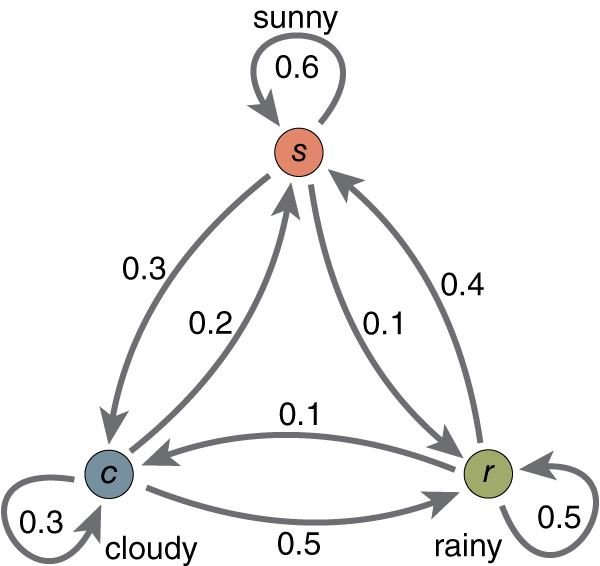

In [3]:
Image('markov_chain.png', width=500)

## <font color=#D28140><u>Exercise:</u></font>
- Guess which state will be sampled most often?

- Implement the weather forecast example and draw 1000 samples:
    - Define the transition matrix $P$.
    - Sample a random start state $X_0$ with <code>rng.integers(endpoint)</code>.
    - Sample the next states based on the transition matrix with <code>rng.choice(a, p)</code>.
    - Plot your sampling distribution as histogram with <code>plt.hist()</code>. Is the result in line with your guess?

In [3]:
rng = np.random.default_rng() # initialize random number generator

In [ ]:
nSamples = # set number of samples

states = ['sunny :)', 'cloudy :/', 'rainy :(']

transMat = # define transition matrix

stateVec = np.zeros(nSamples, dtype=int) # preallocation

stateVec[0] =  # sample initial state

# sample 
for s in range(1,nSamples):
    stateVec[s] = # sample new state based on current state and transition matrix

# plot result
plt.figure()
plt.hist(stateVec, density=True)
plt.xticks(np.arange(3), states)
plt.show()

## Monte Carlo
Monte Carlo means to use repeated sampling to simulate a process. Monte Carlo sampling is often used when it's difficult or impossible to calculate the exact solution. For instance, I don't know how to calculate the probability that two people from a group have their birthday on the same day. But I can sample thousands of birthdays, check if two are identical, and calculate the proportion. The more samples I draw the better is my approximation of the real probability.

## MCMC
MCMC methods approximate the posterior distribution sampling a Markov Chain. MCMC samplers can evaluate the product of prior and likelihood at a given parameter value $x$. This corresponds to the point-wise density of the posterior $p(x)$.

One of the simplest MCMC sampling algorithms is <b>Metropolis-Hastings</b> which was introduced 1970. Metropolis-Hastings is defined as follows:
1. Initialize the value of the parameter $X$ at $x_i$
2. Use a proposal distribution $q(x_{i+1}\mid x_i)$ to generate a new value $x_{i+1}$ from the old one $x_i$ ($\to$ Markov Chain)
3. Compute the probability of accepting the new values as:
$$p_a(x_{i+1}\mid x_i)=\min\left(1,\frac{p(x_{i+1})q(x_i\mid x_{i+1})}{p(x_i)q(x_{i+1}\mid x_i)}\right)$$
4. If $p_a>R$ where $R\sim\mathcal U(0,1)$, save the new value, otherwise save the old one
5. Iterate 2 to 4 until a sufficiently large sample of values has been generated

This algorithm ensures that regions with a higher probability density will always be accepted and moving to a region with lower probability density is probabilistic. Hence the sampler explores the posterior distribution and will visit regions with higher density more often.

Modern MCMC samplers are not so simple anymore. PyMC uses as default the <b>No-U-Turn sampler (NUTS)</b>. If you want to take a deep dive into the math, look here: https://www.youtube.com/watch?v=a-wydhEuAm0.

## <font color=#D28140><u>Exercise:</u></font>
We can try to impelement a Metropolis-Hastings sampler by ourselves. As example we can use the Beta-Binomial model:
$$\theta\sim\text{Beta}(\alpha,\beta)\\
Y\sim\text{Bin}(n=1, p=\theta)$$
Here we have one parameter $\theta$ that represents the proportion of succes. We select a Beta distribution as prior. Our data $Y$ follows a Binomial distribution, which is the likelihood.

- Implement a Metropolis-Hastings sampler for the Beta-Binomial model:
    - Set the real $\theta$ and sample some data with <code>stats.bernoulli(theta).rvs(n)</code>.
    - Set your prior, i.e. select values for $\alpha$ and $\beta$.
    - Set the number of samples (<code>nSamples</code>) you want to draw with your sampler.
    - Sample an initial value for $\theta$ with <code>rng.random()</code>.
    - Calculate the posterior for this sampled $\theta$. Use <code>stats.beta(alpha, beta).pdf(theta)</code> for the prior and <code>stats.bernoulli(theta).pmf(Y).prod()</code> for the likelihood.
    - Loop over <code>nSamples</code>:
        - Draw a new candidate $\theta$. You can use a Normal distribution <code>rng.normal(theta, std)</code>. Choose a small standard deviation, because $\theta$ can only range between 0 and 1.
        - Check if your candidate $\theta$ is between 0 and 1. If yes calculate the posterior for the candidate $\theta$, if not set the posterior to <code>-np.inf</code>.
        - Calculate $p_a$ by dividing the posterior of the candidate $\theta$ by the posterior from the current $\theta$.
        - Check if $p_a$ is higher than a random number between 0 and 1 (you can use <code>rng.random()</code> again). If it's higher replace the current $\theta$ with the candidate $\theta$ and also replace the posterior.
        - Save $\theta$.
    - Plot your trace with <code>az.plot_trace(trace)</code> and look at the statistics with <code>az.summary(trace, kind='stats')</code>.

- Play around with different priors, standard deviations, number of samples, and number of data points.
- How could the sampler be improved?

In [9]:
# set theta and sample some data
thetaReal = 
n = # number of samples
Y = # sample data

# set features of sampling
nSamples =  # set number of MCMC samples
trace = np.zeros(nSamples) # preallocation
alpha =  # set prior
beta =  # set prior

# sample initial theta
theta = 

# calculate posterior for this initial theta
prior = 
likelihood = 
posteriorOld = 

# loop over samples
for i in range(nSamples):

    # sample a new theta based on the old theta
    thetaCandidate = 

    # calculate the posterior density of the candidate theta if it's between 0 and 1
    # if yes: calculate posterior; if not: set posterior to -inf that ensures that old theta is saved
    if 0<=theta<=1:
        prior = 
        likelihood = 
        posteriorNew = 
    else:
        posteriorNew = -np.inf

    # calculate pa
    pa = 

    # check if pa is higher than a random number between 0 and 1; if yes replace theta and posterior with candidate theta
    if pa>rng.random():
        theta = 
        posteriorOld = 
    
    # save theta
    trace[i] = theta

In [ ]:
print(az.summary(trace, kind='stats'))
az.plot_trace(trace);

#### References:
Gelman, A., & Nolan, D. (2017). <i>Teaching Statistics</i>. Oxford University Press.

Martin, O. A., Kumar, R., & Lao, J. (2022). <i>Bayesian Modeling and Computation in Python.</i> Chapman and Hall/CRC.

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jun 17 2024

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.20.0

seaborn   : 0.12.2
numpy     : 1.25.2
matplotlib: 3.8.4
scipy     : 1.12.0
arviz     : 0.17.1

Watermark: 2.3.1

